# Draft

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import datetime as dt

from typing import List

jtplot.style(figsize=(15, 9))

<AxesSubplot:xlabel='Datetime'>

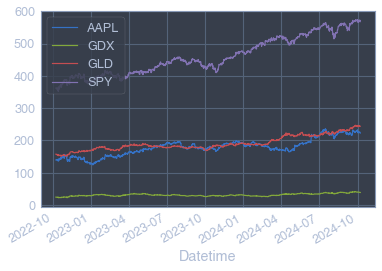

In [32]:
df = pd.read_csv('../../../data/bt/gld_gdx_aapl_spy__1H.csv', parse_dates=True, header=[0, 1], index_col=0)
df['Close'].plot()

## SMA

In [19]:
data = pd.DataFrame(df['Close']['GDX'])
data.rename(columns={'GDX': 'price'}, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3492 entries, 2022-10-07 14:30:00-04:00 to 2024-10-07 14:30:00-04:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   3492 non-null   float64
dtypes: float64(1)
memory usage: 40.9+ KB


<AxesSubplot:xlabel='Datetime'>

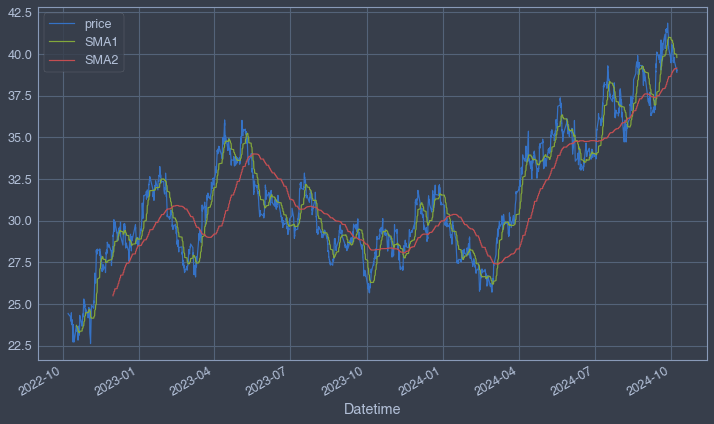

In [20]:
data['SMA1'] = data['price'].rolling(42).mean()
data['SMA2'] = data['price'].rolling(252).mean()

data.plot()

In [21]:
data.dropna(inplace=True)

In [22]:
data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
data['returns'] = np.log(data['price'] / data['price'].shift(1))

data['strategy'] = data['position'].shift(1) * data['returns']

In [29]:
returns = data[['strategy', 'returns']].sum().apply(np.exp)
returns.idxmin()

'strategy'

<AxesSubplot:>

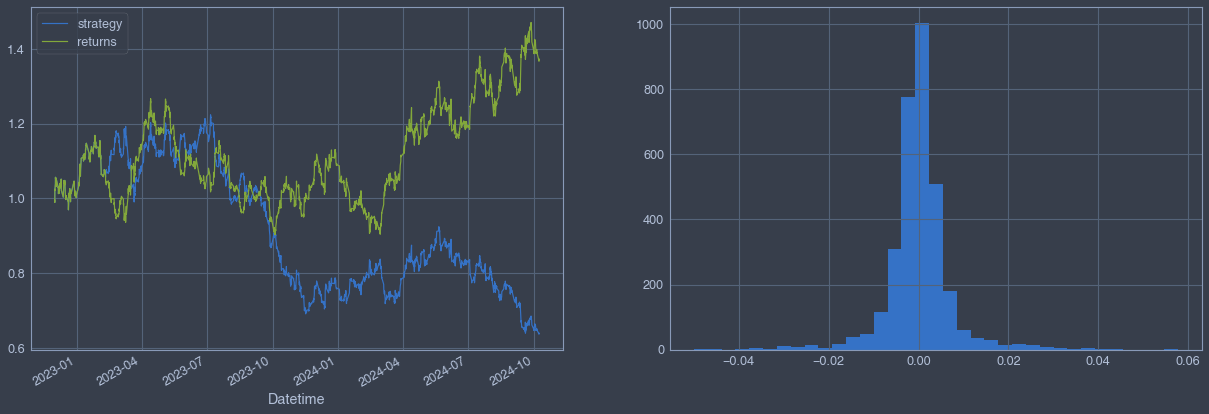

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(21, 7))
data[['strategy', 'returns']].cumsum().apply(np.exp).plot(ax=ax[0])
data['returns'].hist(bins=35, ax=ax[1])

## Class

In [ ]:
DATA_STORAGE = '../../../data'
class SMAVectorBacktester():
    def __init__(self, SMA1, SMA2, data_info):
#         self.symbol = symbol
#         self.start = start
#         self.end = end
#         self.interval = interval
        self.data_info = data_info
        self.data = None
        
        self.SMA1 = SMA1
        self.SMA2 = SMA2
        
        self.results = None
        
        self.get_data()
    
    def get_data(self):
        self.data_prepare()

        self.data = self.data['Close'].to_frame()
        self.data.rename(columns={'Close': 'price'}, inplace=True)
        
        self.data['return'] = np.log(data['price'] / data['price'].shift(1))
    
    def get_data_from_yf(self):
        self.data = yf.download(
            data['symbol'],
            start=data['start'],
            end=data['end'],
            interval=data['interval'],
            
            auto_adjust=True,
            progress=False,
            show_errors=True
        )
    
    def get_data_from_csv(self):
        f = f'{DATA_STORAGE}/{self.data_info}'
        if os.path.isfile(f):
            self.data = pd.read_csv(f'{f}', index_col=0, parse_dates=True)
        
    def data_prepare(self):
        if type(self.data_info) is str and self.data_info[-3:]=='csv':
            self.get_data_from_csv()
    
    def run_strategy(self):
        data = self.data.copy().dropna()
        
        data['SMA1'] = data['price'].rolling(self.SMA1).mean()
        data['SMA2'] = data['price'].rolling(self.SMA2).mean()
        
        data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
        data['strategy'] = data['position'].shift(1) * data['return']
        
        data.dropna(inplace=True)
        
        data['c_returns'] = data['return'].cumsum().apply(np.exp)
        data['c_strategy'] = data['strategy'].cumsum().apply(np.exp)
        
        self.results = data
        
        # gross performance
        aperf = data['c_strategy'].iloc[-1]
        # out / underperformance
        operf = aperf - data['c_returns'].iloc[-1]
        
        return round(aperf, 2), round(operf, 2)
